# Conditionnal Bernoulli

## question 1

`définition des objet`  
Let $N$ be an integer, and consider the probability vector $p = (p_1, p_2, \dots, p_N)$ where each $p_i$ belongs to the interval $(0,1)$ for  $i = 1, \dots, N$.  
The sample space is given by $\Omega = \{0,1\}^N.$  
We assume that $I$ is an integer satisfying $I \leq \frac{N}{2}$.  
Let $g$ be the probability density function of the random vector  
$$
(X_1, \dots, X_N)
$$
where the $X_i$ are independent Bernoulli random variables $X_i \sim \mathsf{B}(p_i).$  
Finally, let $f$ be the probability density function of  
$$
(X_1, \dots, X_N) \sim \mathsf{CB}(p, I).
$$  

`justification du choix de ce que l'on fait`
We will use the following proposition from the lecture :
> Let $f$, $g$ be probability density functions (PDFs) such that the support of $g$ contains the support of $f$ and
> 
> $$
> f \leq M g \quad \text{with } M \geq 1.
> $$
> 
> ### Accept-Reject Algorithm
> Repeat:  
> 1. Draw $X \sim g$ and $U \sim U[0,1]$.  
> 2. Until $U \leq \frac{f(X)}{M g(X)}$.
> 
> ### Properties:
> - $X \sim f$ 
> - The number of draws until acceptance follows a **Geometric** distribution:  
>   
>   $$
>   \text{Geometric}(1/M).
>   $$  

This propriety can be used because $g$ does not cancel out `j'imagine que c'est comme ça que se dit ne s'annule pas` on $\Omega$.  
We choose the smallest possible $M$ in order to have as little draws as possible 
$$
M = \underset{x \in \Omega}{\sup} \; \frac{f(x)}{g(x)}
$$

<u>Remark</u> : 

Because $N$ is fixed, that's actually a max. 

$$ M = \underset{x \in \Omega}{\max} \; \frac{f(x)}{g(x)}$$

### algorithm du cours aucun changement

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import geom
from collections import deque

`on mettra sûrement la classe dans un fichier .py pour que ça soit plus lisible`

'Ne penses-tu pas qu'il faudrait iporter intertools comme "import intertools as inter" ? ça serait plus propre non ? '

In [2]:
class RejectionSampling:
    def __init__(self, p, I):  # Default value for m
        self.p = p
        self.I = I
        self.N = len(p)
        self.g = self.pdf_bernoulli(p)  # Bernoulli probability function
        self.f = self.pdf_cb(p, I)  # Conditional probability function
        self.M = self.compute_M(self)  # Compute M
        self._sample = None
        self._acceptances = None
    
    @staticmethod
    def compute_M(self):
        """Computes M based on given m and probability ratios"""
        res = 1
        for seq in self.generate_sequences(self.N, self.I):  # Corrected N and I
            pr = self.f(seq) / self.g(seq)  # Fix missing self.
            if pr > res:
                res = pr
        return res

    def pdf_cb(self, p, I):
        """Computes a conditional probability function"""
        g = self.pdf_bernoulli(p)
        proba = 0
        for x in self.generate_sequences(len(p), I):
            proba += g(x)

        def f(x):
            return g(x) / proba if np.sum(x) == I else 0  # Use np.sum(x)

        return f

    @staticmethod
    def generate_sequences(N, I):
        """Generates all binary sequences of length N with I ones"""
        positions = itertools.combinations(range(N), I)
        sequences = []
        for pos in positions:
            seq = np.zeros(N, dtype=int)  # Start with all zeros
            seq[list(pos)] = 1  # Set the specified positions to 1
            sequences.append(seq)
        return np.array(sequences)

    @staticmethod
    def pdf_bernoulli(p):
        """Creates a Bernoulli probability function"""
        def g(x):
            return np.prod(np.where(x == 1, p, 1 - p))
        return g
    
    def sample(self,L=1):
        samples = []
        acceptances = []
        while len(samples) < L:
            attempt = 0
            while True:
                attempt += 1 
                X = np.array([np.random.binomial(1, p_i) for p_i in self.p])
                U = np.random.uniform(0,1)
                if U<=(self.f(X)/(self.g(X)*(self.M))):
                    samples.append(X)
                    acceptances.append(attempt)
                    break
        self._sample=np.array(samples)
        self._acceptances = np.array(acceptances)
    
    def plot_acceptance_density(self):
        """Plots the empirical density function and the theoretical Geometric(1/M) density."""
        if self._acceptances is None:
            print("No samples generated yet. Run sample() first.")
            return

        unique, counts = np.unique(self._acceptances, return_counts=True)
        empirical_density = counts / np.sum(counts)  # Normalize to get probability values

        # Theoretical geometric distribution with success probability 1/M
        k_values = np.arange(1, max(unique) + 1)  # Range of values for plotting
        theoretical_density = geom.pmf(k_values, 1 / self.M)  # Geometric PMF

        plt.figure(figsize=(8, 5))
        
        # Empirical density as a bar plot
        plt.bar(unique, empirical_density, width=0.8, color='b', alpha=0.7, edgecolor='black', label="Empirical Density")
        
        # Theoretical geometric density as a line plot
        plt.plot(k_values, theoretical_density, 'r-o', markersize=4, label=f"Theoretical Geom(1/{self.M:.2f})", linewidth=1)

        plt.xlabel("Number of Attempts Before Acceptance")
        plt.ylabel("Probability Density")
        plt.title("Empirical vs Theoretical Density of Acceptance Attempts")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

Pour $I$ fixer on va évaluer comment évolue $M$; pour ce fair on va considérer des $p_i$ uniforme sur $(0,1)$. On remarque que pour un $N$ donnée, $M$ va avoir des valeurs extrème essentiellement plus hautes que sa moyenne quartile etc.; pour plusieurs N, on va avoir une croissance des valeurs extrèmes M exponentielle; 

/tmp/ipykernel_125966/3210251214.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])


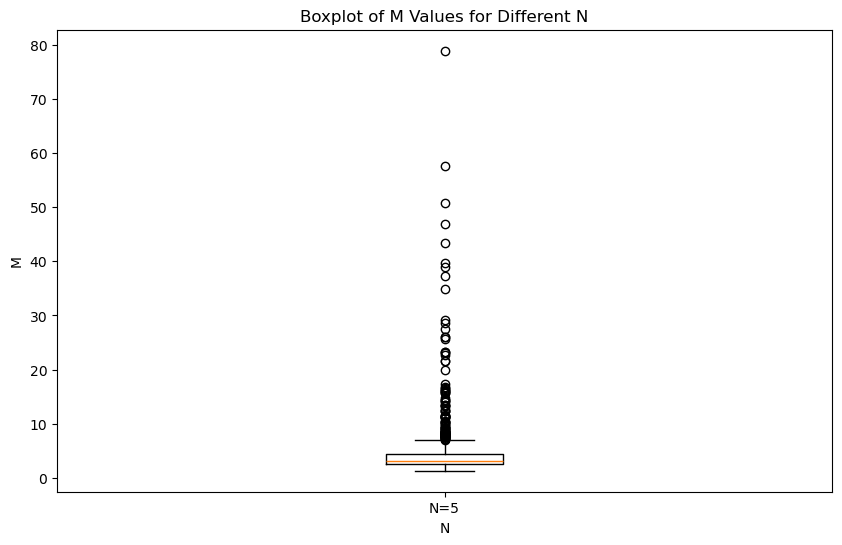

In [3]:
I = 2
num_samples = 1000  # Number of samples to run
N_values = [5]  # Different values for N
M_values_all = []  # To hold M values for each N

# Collect M values across multiple samples for different N
for N in N_values:
    M_values = []
    for _ in range(num_samples):
        p = np.random.uniform(0, 1, N)  # Generate random probabilities p
        sampler = RejectionSampling(p, I)
        M_values.append(sampler.M)
    M_values_all.append(M_values)

# Create a boxplot for each N
plt.figure(figsize=(10, 6))
plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])
plt.title('Boxplot of M Values for Different N')
plt.ylabel('M')
plt.xlabel('N')
plt.show()

/tmp/ipykernel_125966/2752977224.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])


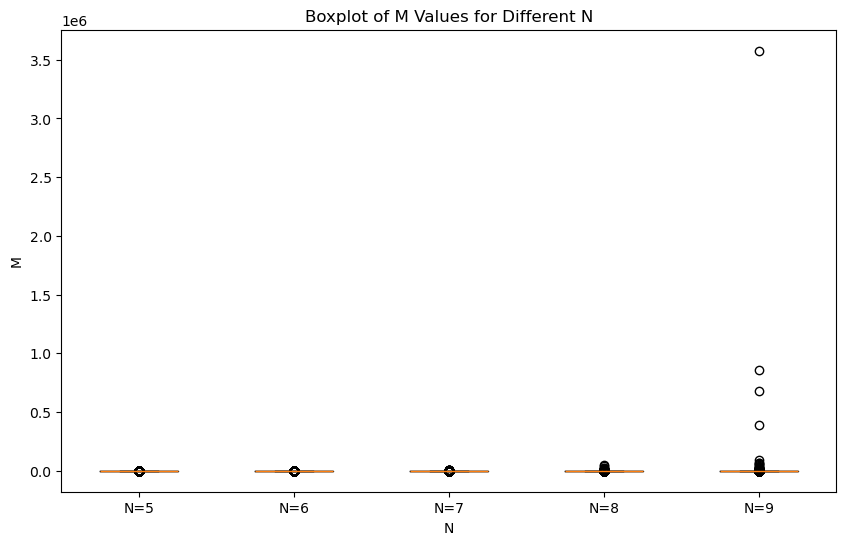

In [4]:
I = 2
num_samples = 10000  # Number of samples to run
N_values = [5,6,7,8,9]  # Different values for N
M_values_all = []  # To hold M values for each N

# Collect M values across multiple samples for different N
for N in N_values:
    M_values = []
    for _ in range(num_samples):
        p = np.random.uniform(0, 1, N)  # Generate random probabilities p
        sampler = RejectionSampling(p, I)
        M_values.append(sampler.M)
    M_values_all.append(M_values)

# Create a boxplot for each N
plt.figure(figsize=(10, 6))
plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])
plt.title('Boxplot of M Values for Different N')
plt.ylabel('M')
plt.xlabel('N')
plt.show()

## Question 2

Implementation of the algorithm. This make a "real" conditional Bernoulli according to the paper.

In [5]:
def sample_conditional_bernoulli(p , I : int):
    """ Take as parametter a list or an array p, which represent the vector of probabilities
     and an int I the bound for x_1+ ...+x_n
    """
    
    #initialization
    p = np.array(p)
    N = len(p)
    q = np.zeros((I + 1, N))
    
    #first condition, if I =0, the conditionnal bernouilli is obviously a vector of 0, for all n in [N] ([N] = {1,...,N})
    if I == 0:
        return np.array([0 for k in range(N)])
    else : 

        # first conditions (first raw is just the product of the probabilities)
        for n in range(N):
            q[0][n] = np.prod(1 - p[n:])

        #the last row of the first column is just p_N
        q[1][N - 1] = p[N - 1]

        # filling of the probability matrix 
        for n in range(N - 2, -1, -1):
            for i in range(1, min(I, N - n) + 1): #+1 because the first row is already made
                q[i][n] = p[n] * q[i - 1][n + 1] + (1 - p[n]) * q[i][ n + 1 ]

        # sampling
        x = np.zeros(N, dtype=int)
        for n in range(N):
            if I > 0:
                prob = q[I, n]
                #condition for get exactly I x_n = 1 and not less
                if n < N - I and prob !=0: # (actually, the second condition is always true for N finite)
                    prob_if_one = p[n] * q[I - 1, n + 1] / prob
                    if np.random.rand() < prob_if_one :#We add this ondition to obtain a random variable
                        x[n] = 1
                        I -=1
                    else :
                        x[n] = 0
                else:
                    x[n] = I
                    I -= 1
        return x

In [20]:
#test

x = sample_conditional_bernoulli([1/2 for i in range(10)], 4)
np.count_nonzero(x),x


(4, array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0]))

The construction of the matrix in our ‘sample_conditional_bernoulli’ function is of size $O(N^2)$. Indeed, we know that $I \alpha N$ at most (because $I \le \frac N2$) and so, the double loop is indexed on $\{1,... N-2\}$, and then on $\{1,...,I\}$ ($I$ proportional to $N$) in the "best" case and in the "worst" case, the second loop is repeated $N-1$ times. Thus, the complexity of this loop is $O(N^2)$.

For the second operation of the algorithm, we just get a loop on $\{1, \ldots, n\}$, thus we get a complexity of $O(N)$.

Therefore, we can conclude that the complexity is in order $O(N^2) + O(N) = O(N^2)$.

## Question 3

We now implement a Markov Chain Monte Carlo (MCMC) algorithm to sample from the conditional Bernoulli distribution $\mathrm{CB}(p, I)$ defined over the space:

$$
\Omega' := \left\{ x \in \{0,1\}^N \mid \sum_{i=1}^N x_i = I \right\}
$$

We initialize a vector $X \in \Omega'$ such that $\sum X_i = I$. For now, $X$ is <u> not random</u> (we simply permute $I$ ones and $N - I$ zeros). Indeed, $P(X_n = k| \sum_{i=1}^{N}X_i = N) = 0$ if $k \ne 1$ and $=1$ if $k=1$. Symmetrically, we obviously get $P(X_n = k| \sum_{i=1}^{N}X_i = 0) = 0$ if $k \ne 0$ and $=1$ if $k=0$.

Note that we exclude the trivial cases where $I = 0$ or $I = N$, since in those cases, the chain would be constant and there is no randomness:

- $\mathrm{CB}(p, N)$ is concentrated on the vector $(1,\dots,1)$,
- $\mathrm{CB}(p, 0)$ is concentrated on the vector $(0,\dots,0)$.

At each step, we propose a swap between:
- a random index $i_1$ where $X_{i_1} = 1$,
- and a random index $i_0$ where $X_{i_0} = 0$,

and accept this swap with probability:

$$
\alpha = \min\left(1, \frac{p_{i_0}/(1 - p_{i_0})}{p_{i_1}/(1 - p_{i_1})} \right)
$$

We denote $Y_n$ the current state of the chain, i.e. $Y_n \in \Omega'$.

Let $Y_n = x$ and let $S_1(x)$ and $S_0(x)$ be the sets of indices where $x_i = 1$ and $x_i = 0$, respectively. 

At each iteration, the algorithm:
- picks $(i_1, i_0) \in S_1(x) \times S_0(x)$,
- proposes $x' = x$ with entries $i_1 \leftrightarrow i_0$ swapped,
- accepts this move with a probability that depends **only on $x$ and $x'$**, not on earlier history.

Hence, the transition probability:

$$
P(Y_{n+1} = x' \mid Y_n = x) = q(x \to x') \cdot \alpha(x, x')
$$

In fact, we get $(Y_i)_{i \in [num iterations]}$ is a Markov Chain because $Y_i$ just depend on $Y_{i-1}$, for all $n$. 

Let's prove it. 

Let $Y_n = (Y_n^{(1)}, \ldots, Y_n^{(N)})$ a random variable to $\Omega' = \big\{x \in \Omega \mid \sum_{i=1}^Nx_i = I \big\}$ and $i \in [N]$. Let also the set $I_n \in [N]$ which represent the index $(i)$ where $Y_i^{(i)} = 1$, this set <u>just depend on $Y_i$</u>.

Let $i \in [N], k$ an integer :

\begin{align*}
    P(Y_{k+1}^{(i)} = 1)&=P(Y_{k}^{(i)} = 0)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 0)] + P(Y_{k}^{(i)} = 1)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 1)]\\
    &= \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-P(Y_{k+1}^{(i)} = 0| Y_{k}^{(i)} = 1)] \\
    & = \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-\frac 1I \min(1, \frac{\sum_{i \in I_n^c}1-p_j}{1-p_i})]
\end{align*}

(Note that we could just left the value $P(Y_{k}^{(i)} = 0)$ to show the property)

With the same reasoning on $P(Y_{k+1}^{(i)}=0)$, we can conclude that ($Y_i$) is a Markov chain, because it just depend on the previous value of $Y_{k-1}$. 

So, $(Y_i)$ does depend only on the **current state** $x = Y_n$.  


Therefore, the process $(Y_n)_{n\geq 0}$ satisfies the **Markov property**:

$$
\mathbb{P}(Y_{n+1} \mid Y_n, Y_{n-1}, \dots, Y_0) = \mathbb{P}(Y_{n+1} \mid Y_n)
$$

- The MCMC algorithm uses **local proposals** (1-to-0 and 0-to-1 swaps),
- The chain is **Markovian** by construction,

We can now use this chain to sample approximately from the conditional Bernoulli distribution $\mathrm{CB}(p, I)$. (See the proof below)


<!-- ---

Let's implement the MCMC (Markov Chain Monte Carlo).

For this, we initialize a vector $X$ which respect the condition $\sum_{i=1}^{N}X_i = I$ (for the moment, X is NOT random). After, if I isn't equal to $0$ or $N$ (because there is no random with that configuration), indeed, $P(X_n = k| \sum_{i=1}^{N}X_i = N) = 0$ if $k \ne 1$ and $=1$ if $k=1$. Symmetrically, we obviously get $P(X_n = k| \sum_{i=1}^{N}X_i = 0) = 0$ if $k \ne 0$ and $=1$ if $k=0$.

Afterward, we just "swap" the different element of our vector $X$ with probability "$\min(1,\frac{w_{i_0}}{w_{i_1}})$" like it is indicated in the paper.

In this algorithm,
$(Y_i)_{i \in [num iterations]}$ is a Markov Chain because $Y_i$ just depend on $Y_{i-1}$, for all $n$. Let's prove it. Let $Y_n = (Y_n^{(1)}, \ldots, Y_n^{(N)})$ a random variable to $\Omega' = \big\{x \in \Omega \mid \sum_{i=1}^Nx_i = I \big\}$ and $i \in [N]$. Let also the set $I_n \in [N]$ which represent the index $(i)$ where $Y_i^{(i)} = 1$, this set <u>just depend on $Y_i$</u>.

Let $i \in [N], k$ an integer :

\begin{align*}
    P(Y_{k+1}^{(i)} = 1)&=P(Y_{k}^{(i)} = 0)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 0)] + P(Y_{k}^{(i)} = 1)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 1)]\\
    &= \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-P(Y_{k+1}^{(i)} = 0| Y_{k}^{(i)} = 1)] \\
    & = \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-\frac 1I \min(1, \frac{\sum_{i \in I_n^c}1-p_j}{1-p_i})]
\end{align*}

(Note that we could just left the value $P(Y_{k}^{(i)} = 0)$ to show the property)

With the same reasoning on $P(Y_{k+1}^{(i)}=0)$, we can conclude that ($Y_i$) is a Markov chain, because it just depend on the previous value of $Y_{k-1}$. -->

In [7]:
def mcmc_conditional_bernoulli(p, I : int, num_iterations : int):
    p = np.array(p)
    N = len(p)
    # Let's make a X which respect the constraint sum X_i = I
    X = np.zeros(N, dtype=int)
    X[:I] = 1
    np.random.shuffle(X)
    odds = p / (1 - p)
    S0 = list(np.where(X == 0)[0])
    S1 = list(np.nonzero(X)[0])
    
    for nb_iter in range(num_iterations):
        # random selection of 1 and 0
        np.random.shuffle(S0)
        np.random.shuffle(S1)

        # let's take a random element of our index_0/1
        i = S1.pop()
        j = S0.pop()

        # Compute the probability of acceptance
        acceptance_prob = min(1, odds[j] / odds[i])

        # reject or acceptance's swap
        if np.random.rand() < acceptance_prob: # "accept with probability acceptance_prob"
            X[i], X[j] = 0, 1
            S0.append(i)
            S1.append(j) 
        else : #restores origninals values else
            S0.append(j)
            S1.append(i)

    return X

In [23]:
#test
x = mcmc_conditional_bernoulli([1/2 for i in range(1_000)],497, 10_000) 
np.count_nonzero(x)

497

#### Why does this algorithm works ? 

We already proved that $(Y_i)$ is a Markov Chain to $\Omega'$. Let's suppose that $(Y_n) \sim h$, we have $\pi$ the target probability density of $(X_1, \ldots X_N| \sum_{i=1}^{N}X_i = I)$. To apply the Metropolis Hastings algorithm, we need to check out the conditions :

- (1) $(Y_i)$ is ergodic (irreducible, recurrent, positive, aperiodic) 

- (2) reversibility : for all $x,y \in \Omega', h(x|y) = h(y|x)$, and thus, show that for all $x,y \in \{0,1\}$, we have $\pi(x)h(x|y) = \pi(y)h(y|x)$

Then, when we'll show this, we'll have shown that we have simulated the conditional Bernouilli, because $\pi$ is the conditional law of $X_1, \ldots, X_n \sim f,\quad X_1 \ldots X_N |\sum_{i=1}^nX_i=I = \text{CB}(p,I)$, then we get the targeted density $f$ which is the $n^{th}$ component of $(Y_n)$. But $Y_i^{(n)}$ with (1) and (2) does converge (when $i \to \infty$) to $f$, thanks to the ergodic theorem, it will show that this algorithm (Metropolis Hastings) below is valide. 


the **Markov chain** $(Y_i)_{i \geq 0}$ on $\Omega'$ with:

- Initial state $Y_0 \in \Omega'$, sampled uniformly.
- At each iteration $i$, choose a pair $((i,j))$ such that:
  - $j1 \in S_1(Y_i) $ (i.e., $ Y_i[j1] = 1 $),
  - $j0 \in S_0(Y_i) $ (i.e., $ Y_i[j0] = 0 $),
- Propose a **swap**: define $(Y_i')_{i \ge 0}$ by exchanging $Y_i[j0] \leftrightarrow Y_i[j1]$.
- Accept $Y_i'$ with probability:

$$
\boxed{
\alpha(Y_i, Y_i') = \min\left(1, \frac{\pi(Y_i')}{\pi(Y_i)}\right) = \min\left(1, \frac{\text{odds}_{j0}}{\text{odds}_{j1}} \right)
}
\quad \text{where } \text{odds}_{j0} := \frac{p_{j0}}{1 - p_{j0}}
$$

Then, $Y_{i+1} = Y_i'$ with probability $\frac{p_{j0}}{1 - p_{j1}}$ and $Y_{i+1} = Y_i$ elsewhere.


And thus, if we proved (1) and (2), we we proved the efficiency of our algorithm thanks to Metropolis Hastings which ensures us that $Y_i \overset{\text{(d)}}{\underset{i \to \infty}{\longrightarrow}} \pi $.


<u> Proof :</u>

- (1) Because $N$ is finite, $\Omega'$ is also finite and $(Y_i)_{i \ge 0}$ is a Markov chain irreducible (clearly, because, all the state of $\Omega'$ are available and communicate) to $\Omega'$ finite. Thus we can say that ($Y_i$) is also recurrent and positive. Furthermore, for all state $x \in \Omega'$, we can find a period stay to this stat with probability not null, and thus, our chain $(Y_i)_{i \ge 0}$ is aperiodic. Thus $(Y_i)_{i \ge 0}$ is an ergodic Markov Chain and so does converge to it's invariant probability $\pi$.

- (2) $h$ is the probability density of $(Y_i)_{i \ge 0}$, because the problem is symmetrical, that is clear that for all $x,y \in \Omega'$, we get 

$$h(x|y) = P(Y_{k+1} = x|Y_k = y) = P(Y_{k+1} = y|Y_k = x) = h(y|x)$$

Thus, because $\pi(x)$ is the density of $X_1, \ldots, X_n | \sum_{i=1}^nX_i=I$, we get 

$$\pi(x)\alpha \frac{dP_{X_1, \ldots, X_n}(x,I)}{d \mu \otimes \mu} \alpha \Pi_{i=1}^N p_i^{X_i}(1-p_i)^{1-X_i} = \Pi_{i=1}^N (\frac{p_i}{1-p_i})^{X_i}(1-p_i) = \Pi_{i=1}^N(1-p_i) \times \Pi_{i=1}^N (\frac{p_i}{1-p_i})^{X_i} \alpha \Pi_{i=1}^N (\frac{p_i}{1-p_i})^{X_i} =  \Pi_{i=1}^N (\text{odds}_i)^{X_i}$$

 (with $\mu$ the counting measuring). So, we can now conclude because let $x,y \in \Omega'$, we get 

\begin{align*}
    \pi(x)h(x|y) &= \pi(y)h(y|x)\\
    \iff \pi(x)&=\pi(y)\\
    \iff \frac{p_i^{X_i}(1-p_i)^{1-X_i}}{p_i^{X_i}(1-p_i)^{1-X_i}} &= 1
\end{align*}

What is True, so, by the explanation after (1) and (2) in the previous markdown, we showed why this algorithms works. Thus we well have 

$$\boxed{Y_i \overset{\text{(d)}}{\underset{i \to \infty}{\longrightarrow}} \pi} $$

According to the previous statement, we get $(Y_i)$ converges in distribution to $\pi$, the **unique stationary distribution**.

- The chain moves **only within the constrained set**  $\Omega'$.
- Each transition corresponds to swapping a 1 and a 0 — preserving the total number of 1's.
- The **odds ratios** act as importance weights that guide the chain toward configurations favored by \( p \).
- The Markov chain thus **explores the correct target distribution** over time.

### How to asses the mixing of our chain $(Y_i)$ ?


#### first strategy 




To evaluate the mixing of our Chain, and so, know if $(Y_i)$ visit well all the possible states, we use a **coupling-based strategy**. This permit to evaluate the meeting time of two chain $(Y_i), (\tilde Y_i)$ and thus, determine the level of mixing of our algorithm. $ (\tilde Y_i)$ start in an arbitrary state, different from $(Y_i)$. And then, compute the minimum time of meeting of those two chain. The main purpose of the paper is about a non identical distribution of $(p_1, \ldots p_N)$ thus we'll compute the meeting time in this situation.

The main goal here is to assess the velocity of convergence of $(Y_i)$ with our mcmc algorithm.

To explain our approach, this algorithm is based on the statement : if two copy of Markov chain $ (Y_i)_{i \ge 1}$  and $ (\tilde Y_i)_{i \ge 1}$ evolve together but from different states, and end up meeting, we can deduce that one of them is near of the other, and thus, there are near there limit law $\pi$. We already proved why our Markov chain is converging to the conditional Bernoulli law, according to the Metropolis Hastings algorithm, so we can use the convergence of our two Markov chain.


Moreover, we can arg a little bit more mathematically, if we the state that 

- $ (Y_i)$, starting from an arbitrary state $ x \in \Omega'$,
- $ (\tilde{Y}_i) $, starting from a different state $ \tilde{x} \in \Omega'$ at **Hamming distance 2** from $( x )$.

We then run both chains simultaneously using a **maximally coupled transition kernel**, and we record the **first time** they meet (i.e., become equal). This time is called the **meeting time**, denoted :

$$\boxed{\tau := \inf\big\{ t \ge 1 \mid Y_t = \tilde Y_t \big\}}$$ 

This approach is based on the fundamental coupling inequality:

$$\lVert \text{Law}(Y_t) - \pi \rVert_{\mathrm{TV}} \leq \mathbb{P}(Y_t \neq \tilde{Y}_t)$$

Moreover, this probability is estimated by averaging over multiple simulations:

$$ \{\omega \mid Y_t(\omega) \neq \tilde{Y}_t(\omega) \}= \{\omega \mid \tau(\omega) > t \}  \quad \implies \quad \mathbb{P}(Y_t \neq \tilde{Y}_t) = \mathbb{P}(\tau > t) $$

In practice, we generate many coupled pairs $(Y_i, \tilde{Y}_i)$, compute the corresponding meeting times $( \tau_i )$, and choose the smallest time $ t$ such that:

$$\frac{1}{M} \sum_{i=1}^M \mathbf{1}_{\{\tau_i > t\}} \leq \varepsilon$$

Note that here, $\tau_i$ are deterministic, (after computing), to avoid an abuse of language, we can say this is "knowing $\tau_i$". In other word :

$$\lVert \text{Law}(Y_t))-\pi \rVert_{TV}  \le P(Y_t \ne \tilde Y_t) \le \mathbb{E}(\mathbb{1}_{d^{(t)} > 0}) = P(d^{(t)} > 0) = P(\omega \in \Omega \mid \tau(\omega) >t)$$


This procedure helps assess how fast two initially distinct trajectories "forget" their initial state and converge to the same stationary distribution, providing insight into the convergence rate of the algorithm under non-uniform probability vectors $p_1 \ldots p_N$

In [9]:
def swap_mcmc(x, y, p):
    """
    return the common swap of x,y like the function mcmc_conditional_bernoulli for just one iteration.
    That function DOES NOT WORKS if I=N or I=0, but in this case, there is no need to check the mixing. 
    """
    x, y = x.copy(), y.copy()
    odds = p / (1 - p)
    # Making the different set presented in 2.2
    S0_x = list(np.where(x == 0)[0])
    S1_x = list(np.nonzero(x)[0])
    S0_y = list(np.where(y == 0)[0])
    S1_y = list(np.nonzero(y)[0])
    if len(S0_x) == 0 or len(S1_x) == 0 or len(S0_y) == 0 or len(S1_y) == 0:
        raise ValueError("Invalid swap set: one of the chains has I = 0 or I = N.")

    # Maximal coupling for i0
    common_S0 = list(set(S0_x) & set(S0_y)) 
    alpha0 = min(len(common_S0) / len(S0_x), len(common_S0) / len(S0_y))
    # Choose a random i, in common S_0, more we have commmon values, more we would choose them
    if len(common_S0) > 0 and np.random.rand() < alpha0:
        i0 = np.random.choice(common_S0) 
        j0 = i0
    else:
        diff_x = list(set(S0_x) - set(S0_y))
        diff_y = list(set(S0_y) - set(S0_x))
        i0 = np.random.choice(diff_x)
        j0 = np.random.choice(diff_y)

    # Maximal coupling for i1, same as the previous loop
    common_S1 = list(set(S1_x) & set(S1_y))
    alpha1 = min(len(common_S1) / len(S1_x), len(common_S1) / len(S1_y))
    if len(common_S1) > 0 and np.random.rand() < alpha1:
        i1 = np.random.choice(common_S1)
        j1 = i1
    else:
        diff_x = list(set(S1_x) - set(S1_y))
        diff_y = list(set(S1_y) - set(S1_x))
        i1 = np.random.choice(diff_x)
        j1 = np.random.choice(diff_y)

    u = np.random.rand()
    if u < min(1, odds[i0] / odds[i1]):
        x[i0], x[i1] = 1, 0
    if u < min(1, odds[j0] / odds[j1]):
        y[j0], y[j1] = 1, 0

    return x, y

def initial_state_hammer(I : int, N : int):
    """ 
    generate two random vectors x,y which follow x_1+ ... + x_N = I, y_1+ ... + y_N =I AND d(x,y) = somme 1(x_i != y_i) = 2
    """
    x = np.array([1]*I + [0]*(N-I))
    np.random.shuffle(x)

    idx_1 = np.where(x == 1)[0]
    idx_0 = np.where(x == 0)[0]
    i1 = np.random.choice(idx_1)
    i0 = np.random.choice(idx_0)

    y = x.copy()
    y[i1], y[i0] = 0, 1

    return x,y
    
def meeting_time(epsilon : float, M : int, I : int, p, L=1):
    """
    Let L be the lag, epsilon the error, M the number of iteration, I like before
    """
    p = np.array(p)
    N = len(p)
    meeting_time = []
    
    for _ in range(M) :
        x,y = initial_state_hammer(I,N)
        tau = 0
        while True :
            x,y = swap_mcmc(x,y,p)
            tau += 1
            if np.array_equal(x, y): 
                meeting_time.append(tau)
                break
    t = 0
    #print(np.mean(meeting_time), np.max(meeting_time), np.min(meeting_time))
    while True :
        total_variation_t = np.mean([max(0, np.ceil((tau_i - L - t) / L)) for tau_i in meeting_time])
        if total_variation_t <= epsilon :
            return t
        t +=1

def probability_generator(N : int): 
    p = np.array([np.random.uniform(0,1) for _ in range(N)])
    return p



In [10]:
#test : samples = [X.copy()]  # Collect samples 

p = probability_generator(100)

meeting_time(epsilon=0.01,M=500,I=45,p=p) 



598

Thus, we checked that the mixing time is approximately in order $N \log(N)$. Let's see it with a plot.

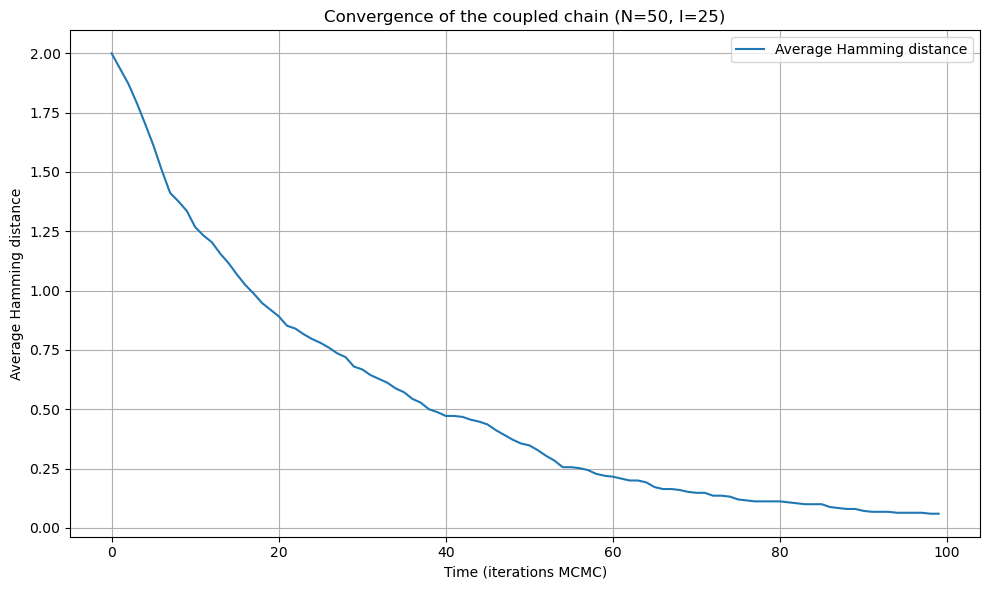

In [11]:

def hamming_distance(x, y):
    return np.sum(x != y)

def simulate_convergence(I, N, p, M=500, max_steps=100): # max step to avoid infinite loop
    distances = np.zeros((M, max_steps))

    for m in range(M):
        x, y = initial_state_hammer(I, N)
        for t in range(max_steps):
            distances[m, t] = hamming_distance(x, y)
            if np.array_equal(x, y):
                # stay at 0 after meeting
                distances[m, t:] = 0
                break
            x, y = swap_mcmc(x, y, p)

    # Mean on the M-trajectory
    mean_dist = distances.mean(axis=0)
    return mean_dist

# Parameters
N = 50
I = 25
p = probability_generator(N)
M = 500       
max_steps = 100

# Simulation
mean_hamming = simulate_convergence(I, N, p, M=500, max_steps=max_steps)


plt.figure(figsize=(10, 6))
plt.plot(mean_hamming, label='Average Hamming distance')
plt.xlabel("Time (iterations MCMC)")
plt.ylabel("Average Hamming distance")
plt.title(f"Convergence of the coupled chain (N={N}, I={I})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Let's see a boxplot to understand the distribution and the reliability of that algorithm 

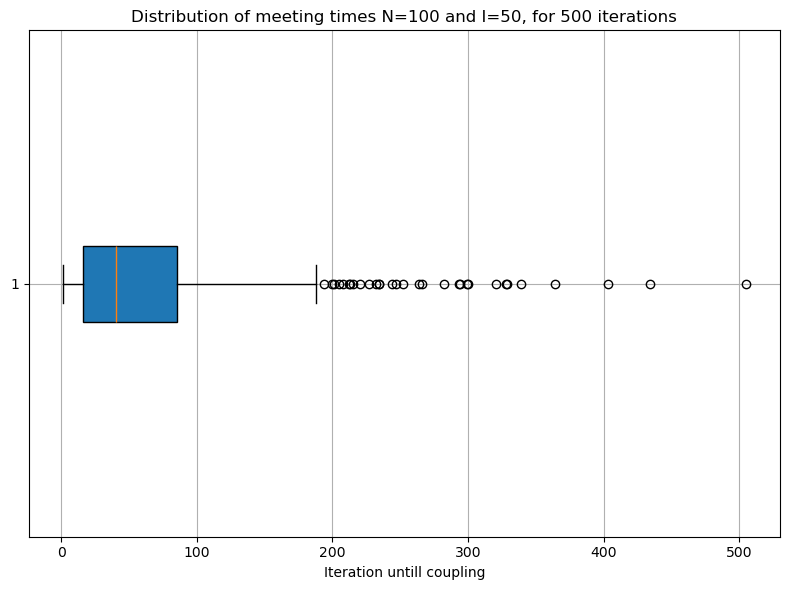

In [12]:
def get_meeting_times(I, N, p, M=500, max_steps=1000): # max step to avoid infinite loop
    meeting_times = []
    for _ in range(M):
        x, y = initial_state_hammer(I, N)
        for t in range(max_steps):
            if np.array_equal(x, y):
                meeting_times.append(t)
                break
            x, y = swap_mcmc(x, y, p)
        else:
            meeting_times.append(max_steps)  
    return meeting_times

# Boxplot
I = 50
N = 100
M = 500
p = probability_generator(N)

meeting_times = get_meeting_times(I=I, N=N, p=p,)
plt.figure(figsize=(8, 6))
plt.boxplot(meeting_times, vert=False, patch_artist=True)
plt.title(f"Distribution of meeting times N={N} and I={I}, for {M} iterations")
plt.xlabel("Iteration untill coupling")
plt.grid(True)
plt.tight_layout()
plt.show()


Well, we notice that in average, for $N=100$, we get a meeting time lower than $100\times \log(100)$ this is an efficient mixing !  

#### Second strategy 

Though we already have answered this question, we can still propose another way to compute the mixing of the algorithm. The main problem with the previous method is the constraint $\mathbb X_{\text{adj}}$ where the Hammer distance is bounded on two. We propose another version where we have $(x)^{(t)}$, $(\tilde x)^{(t)}$ with $x^{(0)} \in \Omega'$ and $\tilde x \sim CB(p,I)$, here we will apply the same logical, the same changes for those two chain, and compute the average time meeting. 

The advantage of that method is to not constraint us to this $\mathbb X_{\text{adj}}$ but the drawbacks is that it is more expansive to compute. We also propose another way to compute the distance, more easy to compute. $P(\tau>t) = \hat d_{TV} $ here, and it is totally okay according to the inequality above.


Mathematically, to explain our method : 

Let:
- $x^{(0)} \in \Omega'$ be an arbitrary initial state such that $\sum x_i = I$,
- $\tilde{x}^{(0)} \sim \text{CB}(p, I)$, drawn from the true target distribution.

Then, we evolve both chains $(x^{(t)})_{t \geq 0}$ and $(\tilde{x}^{(t)})_{t \geq 0}$ **using the same coupled transition kernel** (as before), and record the **first time $\tau$ such that $x^{(\tau)} = \tilde{x}^{(\tau)}$**.

This method is simpler to implement, since we do not require the chains to be initialized at a specific distance, and the coupling mechanism is the same.

According to the coupling inequality, we still have:

$$
\lVert \text{Law}(x^{(t)}) - \pi \rVert_{TV} \leq \mathbb{P}(x^{(t)} \neq \tilde{x}^{(t)}) = \mathbb{P}(\tau > t)
$$

So by estimating $\mathbb{P}(\tau > t)$ empirically, we directly obtain an **upper bound** on the total variation distance to stationarity.

Letting $\hat{\tau}_1, \dots, \hat{\tau}_M$ be $M$ i.i.d. meeting times, we approximate:

$$
\hat{d}_{TV}(t) := \frac{1}{M} \sum_{i=1}^M \mathbf{1}_{\hat{\tau}_i > t}
$$

and return the **smallest $t$ such that $\hat{d}_{TV}(t) \leq \varepsilon$**.


In [13]:
def initial_state(I : int, N : int):
    """ 
    generate random vector x which follow x_1+ ... + x_N = I
    """
    x =np.array([1]*I + [0]*(N-I))
    np.random.shuffle(x)
    return x

def alternative_mcmc_meeting_time(epsilon : float, M : int, I : int, p):
    """
    Alternative way to compute the mixing of our chain, that's normal that the meeting time is larger than the previous method, we do not restrein us to the case where 
    the Hammer distance is equal to two. 
    """
    p = np.array(p)
    N = len(p)
    meeting_time = []
    for _ in range(M):
        tau = 0 
        x = initial_state(I,N)
        y = sample_conditional_bernoulli(p,I)
        while True :
            x,y = swap_mcmc(x,y,p)
            tau += 1
            if np.array_equal(x, y): 
                meeting_time.append(tau)
                break
    t = 0
    while True:
        total_variation_t = np.mean([tau > t for tau in meeting_time])
        if total_variation_t <= epsilon:
            return t
        t += 1
        

In [14]:
# Let's try our alternative algorithm

p = probability_generator(100)

alternative_mcmc_meeting_time(epsilon=0.01,M=500,I=50,p=p) 

2830

Obviously, like we would expect, the meeting time is much larger. 

We can in other hand identify different pros of our method : our algorithm is general, conceptually clean, with no artificial distance constraint subject to requiring a sampling from $\text{CB}(p,I)$, which can be **computationally costly**... 

Indeed, meeting times may be larger on average than in the adjacent initialization case.. 

#### Third strategy 

Finally, we present a third and more theoretically grounded method for estimating the mixing time of our Markov chain.  
We implement **Algorithm 1** from the paper _"Estimating Convergence of Markov Chains with L-Lag Couplings"_ by Biswas, Jacob, and Vanetti (2019), which provides a way to estimate the **total variation distance** of a Markov chain.


We aim to estimate the quantity:

$$
d_{\text{TV}}(\mathcal{L}(x_t), \pi)
$$

where:
- $\mathcal{L}(x_t)$ is the law of the Markov chain at time $t$,
- $\pi$ is the target distribution (here, the conditional Bernoulli law $\text{CB}(p, I)$).

Since we do not know $\mathcal{L}(x_t)$ explicitly, we **construct a coupling** between two chains:
- $(x_t)$, evolving from an arbitrary initial state in $\Omega'$,
- $(y_{t-L})$, a second chain started from another state and updated in parallel,
with a **temporal lag** $L$ between them.

So to compute it, we can say that while $(x_t) \ne (y_{t-L})$, Law $(x_t) \ne \pi$. So, we just have to compute the meeting times and look at them.

Mathematically, we simulate the two chains with lag $L$ using the same coupled kernel, and define the **meeting time** $\tau^{(L)}$ as:

$$\tau^{(L)} = \inf\{t \ge L \mid x_t = y_{t - L} \}$$

according to the paper, we know that 

$$d_{\text{TV}}(\mathcal{L}(x_t), \pi) \le \mathbb{E}[\max(0, \lceil \frac{\tau^{(L)}-L-t}{L}\rceil)] $$

This estimator is **guaranteed to upper-bound** the variation distance and is **monotonically decreasing** in $t$.  
It provides a **rigorous and practical tool** to quantify convergence.

with $\tau^{(L)}$ the meeting time for lag $L$. Thus, this is obvious that it is decreasing with $t$. This method is for us better than the previous, the hammer method is restricted in the case where the hamming distance is equal to 2, and the second is very expensive to compute. This below algorithm is based on theoretical result guaranteed and is not slow to compute. 

In [15]:
def algorithm_1_L_lag_coupling(L, M, I, p):
    """
    Implementation of the first algorithm of the paper.
    Compute and return the meeting time τ^{(L)}
    """
    p = np.array(p)
    N = len(p)
    meeting_times = []

    for _ in range(M):
        # Initialisation
        x = initial_state(I, N)  # X_0
        X_chain = [x]
        for _ in range(L):  # Génerate X_1,...,X_L
            x = swap_mcmc(x, x, p)[0]
            X_chain.append(x)

        y = initial_state(I, N)  # Y_0

        t = L
        while True:
            x_new, y_new = swap_mcmc(X_chain[-1], y, p)
            X_chain.append(x_new)
            y = y_new
            if np.array_equal(x_new, y):
                meeting_times.append(t)
                break
            t += 1

    return meeting_times

In [16]:
def estimate_total_variation(tau_L_list, L, t_max):
    """
    Estimate the total variation distance d_{TV}(π_t=law(x_t), π)
    from meeting times τ^{(L)} for all t ≤ t_max 

    Return : table numpy with d_TV estimate for t = 0, ..., t_max
    """
    tau_L = np.array(tau_L_list)
    M = len(tau_L)
    d_tv = []

    for t in range(t_max + 1):
        # for each t, we compute the contribution max(0, ceil((τ - L - t) / L)) for each trajectory
        individual_bounds = []
        for tau in tau_L:
            bound = (tau - L - t) / L
            bound = max(0,np.ceil(bound))
            #print(bound)
            individual_bounds.append(bound)

        # empirical mean : we asses the uppper bound of d_TV(π_t, π)
        d_tv_t = np.mean(individual_bounds)
        d_tv.append(d_tv_t)

    return np.array(d_tv)


In [17]:
p = probability_generator(N=50)
meeting_times = algorithm_1_L_lag_coupling(L=1, M=500, I=25, p=p)

Let's show as before a histogram to see how are distributed the meeting times, for $M=500$, $I=25$ and $N = 50$.

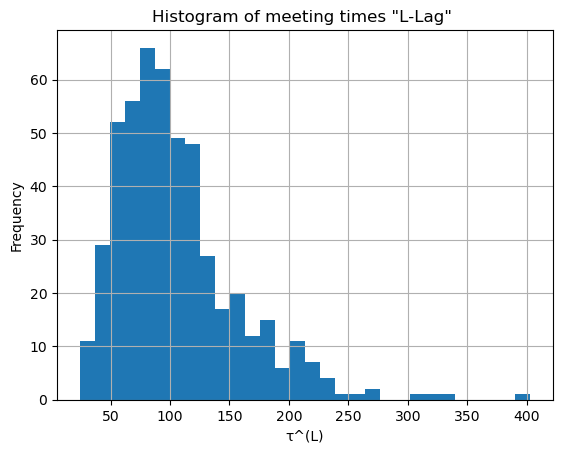

In [18]:
plt.hist(meeting_times, bins=30)
plt.xlabel("τ^(L)")
plt.ylabel("Frequency")
plt.title("Histogram of meeting times \"L-Lag\" ")
plt.grid(True)
plt.show()

And now, we'll show how is decreasing the estimated total variation with number of iteration.

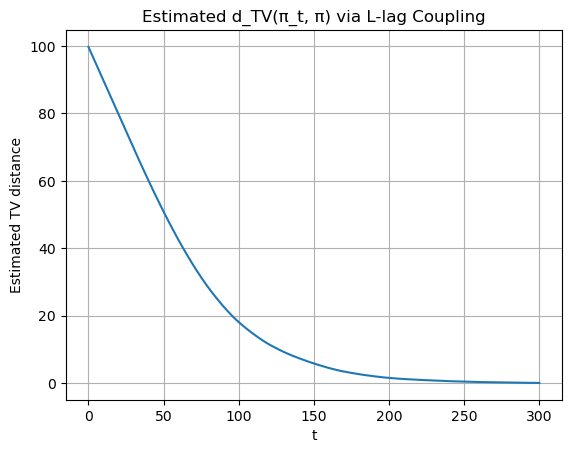

In [19]:
tau_L = algorithm_1_L_lag_coupling(L=1, M=500, I=25, p=p)
d_tv_values = estimate_total_variation(tau_L, L=1, t_max=300)

plt.plot(d_tv_values)
plt.xlabel("t")
plt.ylabel("Estimated TV distance")
plt.title("Estimated d_TV(π_t, π) via L-lag Coupling")
plt.grid(True)
plt.show()

Thus, we can also identify different pros :

- Theoretical Guarantee : Upper bound on $d_{\text{TV}}$ based on a proven inequality
- general and not restricted like the first method
- Efficient : Much faster than parallel chain couplings for high accuracy

and some cons :

-  Requires trajectory storage — One needs to keep $x_0, ..., x_t$ $\implies$ costly in memory.